In [1]:
import os
import copy
import wfdb
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from models_utils import SurrGradSpike, Noisy_Inference, RSNN

In [2]:
### Reproducibility in RNG
seed = 14
torch.manual_seed( seed )
random.seed( seed )
np.random.seed( seed )

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Import the ECG dataset
---

In [3]:
cwd = os.getcwd()
def get_data_ECG(subject_list):
    '''Getting the dataset for the ECG task, from the MIT-BIH collection. This function extracts the channel 1 and 2 from the 
       input list of the subjects (subject_list).'''
    
    # changing directory (where the data is located)
    data_dir = '/Volumes/KINGSTON/Datasets/ECG'
    os.chdir(data_dir)
    
    record = wfdb.rdrecord(f'mit-bih-arrhythmia-database-1.0.0/{100}')
    dt = 1.0 / record.fs
    delta_t = 350e-3
    delta_idx = int(delta_t / dt)

    beat_timeseries_ch1 = []
    beat_timeseries_ch2 = []

    beat_label = []

    for subject in subject_list:

        record = wfdb.rdrecord(f'mit-bih-arrhythmia-database-1.0.0/{subject}')
        annotation = wfdb.rdann(f'mit-bih-arrhythmia-database-1.0.0/{subject}', 'atr')

        for idx,peak in enumerate(annotation.sample):
            if(peak-delta_idx > 0 and peak+delta_idx < np.max(annotation.sample)): # make sure we will have a full sequence

                time_sig1 = record.p_signal[peak-delta_idx:peak+delta_idx,0]
                time_sig2 = record.p_signal[peak-delta_idx:peak+delta_idx,1]
                beat_timeseries_ch1.append(time_sig1)
                beat_timeseries_ch2.append(time_sig2)
                beat_label.append(annotation.symbol[idx])

    beat_timeseries_arr_ch1 = np.asarray(beat_timeseries_ch1)
    beat_timeseries_arr_ch2 = np.asarray(beat_timeseries_ch2)
    beat_label_arr = np.asarray(beat_label)
    
    return (beat_timeseries_ch1,
           beat_timeseries_ch2,
           beat_label_arr)

def delta_modulation( ch, pct_thr=0.9 ):
    '''A simple function that Delta Modulates an input ECG channel at the time'''
    ch_plus2sig = np.percentile(ch.flatten(),pct_thr)
    ch_minus2sig = np.percentile(ch.flatten(),1-pct_thr)
    diff_ch = abs(ch_plus2sig-ch_minus2sig)/10
    ch_dm_up, ch_dm_dn = [], []
    for idx_ch,signal in enumerate(ch):
        prev=-100
        temp_up_list = []
        temp_dn_list = []
        
        for idx,mag in enumerate(signal):
            if (mag-prev > diff_ch):
                temp_up_list.append(time_t[idx])
                prev=mag
            elif (mag-prev < -diff_ch):
                temp_dn_list.append(time_t[idx])
                prev=mag
        ch_dm_up.append(temp_up_list)
        ch_dm_dn.append(temp_dn_list)

    return ch_dm_up, ch_dm_dn

# switching back to the main directory
os.chdir(cwd)

subjects = [208] #or 200
features = get_data_ECG(subjects)
ch1 = np.asarray(features[0])
ch2 = np.asarray(features[1])
beat_label_arr = features[2]

#sort into healthy beats and arrythms
labels_N = np.where(np.asarray(beat_label_arr)=='N')[0]
labels_X = np.where(np.asarray(beat_label_arr)!='N')[0]

pct_thr = 0.9
#set the delta mod thresholds as a function of the spread seen in all the channels signals
ch1_plus2sig = np.percentile(ch1.flatten(),pct_thr)
ch1_minus2sig = np.percentile(ch1.flatten(),1-pct_thr)
diff_ch1 = abs(ch1_plus2sig-ch1_minus2sig)/10

ch2_plus2sig = np.percentile(ch2.flatten(),pct_thr)
ch2_minus2sig = np.percentile(ch2.flatten(),1-pct_thr)
diff_ch2 = abs(ch2_plus2sig-ch2_minus2sig)/10

record = wfdb.rdrecord(f'mit-bih-arrhythmia-database-1.0.0/{208}')
dt = 1.0 / record.fs

# each recording has 250 timesteps
time_idx = np.arange(250)
time_t = np.multiply(time_idx,dt)

ch1_dm_up, ch1_dm_dn = delta_modulation( ch1 )
ch2_dm_up, ch2_dm_dn = delta_modulation( ch2 )
    
#now finally we sort into a point,timesteps,channel binarised matrix
x_data = torch.zeros((len(ch1), len(time_idx), 4))
for i in range(len(ch1)):
    for idx,timestep in enumerate(time_t):
        if(timestep in ch1_dm_up[i]):
            x_data[i,idx,0] = 1.0
        elif(timestep in ch1_dm_dn[i]):
            x_data[i,idx,1] = 1.0
        elif(timestep in ch2_dm_up[i]):
            x_data[i,idx,2] = 1.0
        elif(timestep in ch2_dm_dn[i]):
            x_data[i,idx,3] = 1.0

# create the timeseries labels
y_data = torch.zeros((len(ch1)))
y_data[labels_X] = 1.0

# get our data into a pytorch dataloader
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data.numpy(),y_data.numpy(),test_size=0.5,shuffle=True,random_state=42)

from torch.utils.data import DataLoader, TensorDataset

train = TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train))
test = TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test))

train_loader = torch.utils.data.DataLoader(train, batch_size=16) # 64
test_loader = torch.utils.data.DataLoader(test, batch_size=len(x_test))
            
print ('ECG dataset: loaded')

ECG dataset: loaded


## Defining the parameter of the RSNN
---

In [4]:
fs = record.fs
device = 'cpu'
dtype = torch.float

params = {
    'nb_inputs'  : 4,
    'nb_channels' : 2,
    'nb_hidden'  : 100, # 64
    'nb_outputs' : 2,

    'time_step' : 1/fs,
    'sampling_grequency' : fs,
    'nb_steps'  : x_train.shape[1],
    'lr' : 1e-3,
    
    'tau_mem' : 20e-3,
    'tau_syn' : 5e-3,
    'tech_flag' : True,
    'init_type' : 'unif',
    'weight_scale' : 1,
    'surrogate_grad_scale' : 10,
    'L1_total_spikes' : 1e-7,
    'L2_per_neuron' : 1e-7,

    'noise_inference' : False,
    'noise_sd' : 0.1,

    'batch_size' : 16, # 64
    
    'device' : device,
    'dtype' : dtype,
}

In [5]:
def train(rsnn, params, nb_epochs=10, nb_epochs_noise=2, test_every=20, noise_every=100, training_type='normal', noise_sd=0.1, verbose=False):
    
    optimizer = torch.optim.Adamax(rsnn.parameters(), lr=params['lr'], betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss( )
    
    loss_hist = []; acc_hist = []
    acc_hist_test = []; loss_hist_test = []
    for e in range(nb_epochs):
        local_loss, local_acc = [], []
        rsnn.train()
        for batch_idx, [x_local, y_local] in enumerate(train_loader):
            x_local = x_local.to(device)
            y_local = y_local.type(torch.long).to(device)
            output,recs = rsnn(x_local)
            _,spks=recs
            m,_=torch.max(output,1)
            _,am=torch.max(m,1)
            acc_tmp = np.mean((y_local==am).detach().cpu().numpy())
            local_acc.append(acc_tmp)
            
            log_p_y = log_softmax_fn(m)
            
            # Regularizer loss terms to control the spiking activity in the network
            reg_loss = params['L1_total_spikes']*torch.sum(spks) # L1 loss on total number of spikes
            reg_loss += params['L2_per_neuron']*torch.mean(torch.sum(torch.sum(spks,dim=0),dim=0)**2) # L2 loss on spikes per neuron
            
            # Combining both NLLLoss with the Regularizing loss terms
            loss_val = loss_fn(log_p_y, y_local.type(dtype=torch.long)) + reg_loss

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())

            if e+1 > nb_epochs - nb_epochs_noise and batch_idx%noise_every==0 and training_type == 'noise_fine_tuning':
                with torch.no_grad():
                    for p in rsnn.parameters():
                        delta_w = torch.abs( p.max() )
                        n = torch.randn_like( p )*(noise_sd*delta_w)
                        p.copy_( p+n )
        
        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)
        mean_acc = np.mean(local_acc)
        acc_hist.append(mean_acc)
        if (e+1)%test_every == 0:
            acc_test, loss_test = compute_classification_accuracy(rsnn, params, test_loader, flag_loss=True)
            acc_hist_test.append(acc_test); loss_hist_test.append(loss_test)
        if verbose:
            print("Epoch %i: Train Loss=%.4f, Train Acc=%.4f"%(e+1,mean_loss,mean_acc))
    
    return [loss_hist, acc_hist], [loss_hist_test, acc_hist_test]
        
        
def compute_classification_accuracy(rsnn, params, loader, flag_loss=False):
    """ Computes classification accuracy on supplied data in batches. """
    rsnn.eval()
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    local_loss = []
    accs = []
    for x_local, y_local in loader:
        x_local = x_local.to(device)
        y_local = y_local.type(torch.long).to(device)
        output,_ = rsnn(x_local)
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
        if flag_loss:
            log_p_y = log_softmax_fn(m)
            loss_val = loss_fn(log_p_y, y_local.type(dtype=torch.long))
            local_loss.append( loss_val.item() )
    if flag_loss:
        return np.mean(accs), np.mean(local_loss)
    else:
        return np.mean(accs)

In [ ]:
nb_epochs = 30
test_every = 1

params['nb_outputs'] = 2
params['nb_hidden'] = 100
params['init_type'] = 'unif'
params['weight_scale'] = 1.0 #0.75
params['lr'] = 1e-3
params['tech_flag'] = True
params['tau_mem'] = 20e-3
params['tau_syn'] = 5e-3
params['noise_inference'] = True
params['noise_sd'] = 0.1
params['activation'] = 'spiking'

rsnn = RSNN(params)

# t=0
# training_type = {0:'vanilla', 1:'ste', 2:'noise_fine_tuning'}
# root_path = '/Users/filippomoro/Documents/Training_with_memristors/Models'
# save_checkpoint_path = root_path + '/RSNN_ECG_{}_{}_3.pt'
# data = torch.load( save_checkpoint_path.format( training_type[t], 0 ) )
# rsnn = data['rsnn']
# rsnn.noise_inference = True
# Noisy_Inference.noise_sd = params['noise_sd']
# rsnn.noiser = Noisy_Inference.apply
# rsnn.noise_sd = params['noise_sd']

train_stats, test_stats = train(rsnn, params, nb_epochs=nb_epochs, test_every=test_every, 
                                verbose=True, training_type='vanilla', nb_epochs_noise=2, noise_every=25)

In [ ]:
plt.plot( test_stats[1] )

## Comparison between training procedures
---

In [ ]:
# Vanilla
nb_epochs = 20 # 50
test_every = nb_epochs

params['nb_outputs'] = 2
params['nb_hidden'] = 64
params['init_type'] = 'unif'
params['weight_scale'] = 1.0
params['lr'] = 1e-3
params['tech_flag'] = True
params['tau_mem'] = 20e-3
params['tau_syn'] = 5e-3
params['noise_inference'] = False
params['noise_sd'] = 0.1 #0.15

n_models = 2
noise_sd_list = np.array([0, 0.01, 0.05, 0.1, 0.15, 0.2])
training_type = {0:'vanilla', 1:'ste', 2:'noise_fine_tuning'}

root_path = '/Users/filippomoro/Documents/Training_with_memristors/Models'
save_checkpoint_path = root_path + '/RSNN_ECG_{}_{}_3.pt' #### LOOK I MODIFIED THE FILENAME

i = 0
for m in range(n_models):

    if training_type[i] == 'ste':
        params['noise_inference'] = True
        # data = torch.load( save_checkpoint_path.format( training_type[0], m ) )
        # rsnn = data['rsnn']
        rsnn = RSNN(params)
        params['lr'] = 1e-3
        rsnn.noise_inference = True
        Noisy_Inference.noise_sd = params['noise_sd']
        rsnn.noiser = Noisy_Inference.apply
        rsnn.noise_sd = params['noise_sd']
    else:
        rsnn = RSNN(params)
    train_stats, test_stats = train(rsnn, params, nb_epochs=nb_epochs, test_every=test_every, verbose=True,
                                    training_type=training_type[i], nb_epochs_noise=2, noise_every=25)

    torch.save({
        'nb_epochs': nb_epochs,
        'rsnn': rsnn.to('cpu'),
        'params' : params,
        'train_stats' : train_stats,
        'test_stats' : test_stats
        }, save_checkpoint_path.format( training_type[i], m ))
    print(f'Model {m+1} saved, Test acc: {test_stats[1][-1]}%')

#### The Straight through Estimator technique might be SNN unfriendly
SNNs are spares and do not make use of all the weights at ones. Just a few are used per inference. Maybe this is why the benefits of STE are not so clear for sparse models (SNN), but they are for dense (ANN)

In [58]:
### Saving the results
reps = 5 # 10
n_models = 2
noise_sd_list = np.array([0, 0.01, 0.05, 0.1, 0.15, 0.2])
training_type = {0:'vanilla', 1:'ste'} #{0:'vanilla', 1:'ste', 2:'noise_fine_tuning'}

root_path = '/Users/filippomoro/Documents/Training_with_memristors/Models'
save_checkpoint_path = root_path + '/RSNN_ECG_{}_{}_3.pt' 

acc_vanilla_ecg = np.zeros( ( len( noise_sd_list ),n_models, reps ) )
acc_noise_back_ecg = np.zeros( ( len( noise_sd_list ),n_models, reps ) )
acc_ste_ecg = np.zeros( ( len( noise_sd_list ), n_models, reps ) )

for t in range( len( training_type ) ):
    for n, noise_sd in enumerate( noise_sd_list ):
        for i in range( n_models ):
            for j in range( reps ):
                data = torch.load( save_checkpoint_path.format( training_type[t], i ) )
                rsnn = data['rsnn']
                rsnn.noise_inference = True
                Noisy_Inference.noise_sd = noise_sd
                rsnn.noiser = Noisy_Inference.apply
                rsnn.noise_sd = noise_sd
                test_acc = compute_classification_accuracy(rsnn, params, loader=test_loader)
                if t == 0:
                    acc_vanilla_ecg[n,i,j] = test_acc
                elif t == 1:
                    acc_ste_ecg[n,i,j] = test_acc
                elif t == 2:
                    acc_noise_back_ecg[n,i,j] = test_acc
    print( f'{training_type[t]} finished' )

dict_results = {
    'reps':reps, 'n_models':n_models, 'noise_sd_list':noise_sd_list, 'training_type':training_type,
    'acc_vanilla_ecg':acc_vanilla_ecg, 'acc_noise_back_ecg':acc_noise_back_ecg, 'acc_ste_ecg': acc_ste_ecg
}

import pickle
root_path_results = '/Users/filippomoro/Documents/Training_with_memristors/Results'
file_results = root_path_results + '/ECG_results_3.pkl'
pickle.dump( dict_results, open( file_results, 'wb' ) )

vanilla finished
ste finished


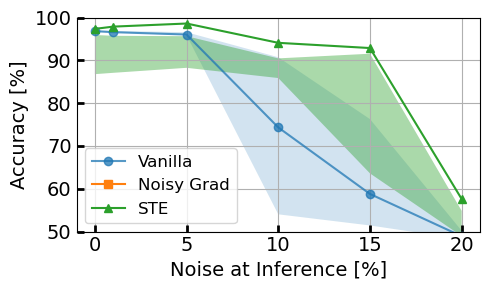

In [62]:
### Plotting the results
import pickle
root_path_results = '/Users/filippomoro/Documents/Training_with_memristors/Results'
file_results = root_path_results + '/ECG_results_3.pkl'
dict_results = pickle.load( open( file_results, 'rb' ) )
noise_sd_list = dict_results['noise_sd_list']

fig, ax = plt.subplots( figsize=(5,3) )
# vanilla
mean = np.median( dict_results['acc_vanilla_ecg'], axis=(1,2))
yerr = np.array( [mean - np.quantile( dict_results['acc_vanilla_ecg'], axis=(1,2), q=0.5-0.25), np.quantile( dict_results['acc_vanilla_ecg'], axis=(1,2), q=0.5+0.25) - mean ] )
ax.plot( noise_sd_list*100, 100*mean, marker='o', ms=6, lw=1.5, label='Vanilla', alpha=0.75 )
ax.fill_between( noise_sd_list*100, 100*np.quantile( dict_results['acc_vanilla_ecg'], axis=(1,2), q=0.5-0.25), 100*np.quantile( dict_results['acc_vanilla_ecg'], axis=(1,2), q=0.5+0.25),
                  alpha=0.2 )
# noise_back
mean_nb = np.median( dict_results['acc_noise_back_ecg'], axis=(1,2))
yerr_nb = np.array( [mean - np.quantile( dict_results['acc_noise_back_ecg'], axis=(1,2), q=0.5-0.25), np.quantile( dict_results['acc_noise_back_ecg'], axis=(1,2), q=0.5+0.25) - mean ] )
ax.plot( noise_sd_list*100, 100*mean_nb, marker='s', ms=6, lw=1.5, label='Noisy Grad' )
ax.fill_between( noise_sd_list*100, 100*np.quantile( dict_results['acc_noise_back_ecg'], axis=(1,2), q=0.5-0.25), 100*np.quantile( dict_results['acc_noise_back_ecg'], axis=(1,2), q=0.5+0.25),
                  alpha=0.2 )
# STE
ax.plot( noise_sd_list*100, 100*np.median( dict_results['acc_ste_ecg'], axis=(1,2)), marker='^', ms=6,  lw=1.5, label='STE' )
ax.fill_between( noise_sd_list*100, 100*np.quantile( dict_results['acc_ste_ecg'], axis=(1,2), q=0.5-0.25), 100*np.quantile( dict_results['acc_ste_ecg'], axis=(1,2), q=0.5+0.25),
                  alpha=0.4 )

ax.set_yticks( np.linspace(50, 100, 6) )
ax.set_ylim( 50, 100 )
ax.set_xlabel( 'Noise at Inference [%]', size=14 )
ax.set_ylabel( 'Accuracy [%]', size=14 )
ax.tick_params( labelsize=14, direction='in', size=5, width=2 )
ax.tick_params( which='minor', direction='in', size=2, width=1 )
ax.grid(True)
ax.legend( prop={'size':12} )

# saving the plot
plt.tight_layout()
file_save_plot = root_path_results + '/ECG_noise_at_inference.pdf'
#fig.savefig( file_save_plot, dpi=300, transparent=True )

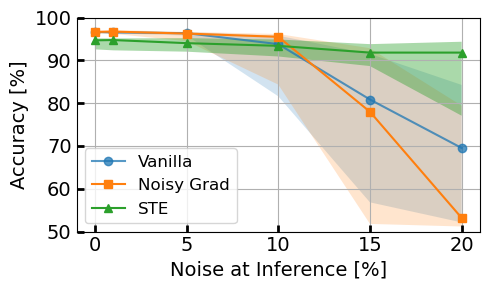

In [51]:
### Plotting the results
import pickle
root_path_results = '/Users/filippomoro/Documents/Training_with_memristors/Results'
file_results = root_path_results + '/ECG_results.pkl'
dict_results = pickle.load( open( file_results, 'rb' ) )
noise_sd_list = dict_results['noise_sd_list']

fig, ax = plt.subplots( figsize=(5,3) )
# vanilla
mean = np.median( dict_results['acc_vanilla_ecg'], axis=(1,2))
yerr = np.array( [mean - np.quantile( dict_results['acc_vanilla_ecg'], axis=(1,2), q=0.5-0.25), np.quantile( dict_results['acc_vanilla_ecg'], axis=(1,2), q=0.5+0.25) - mean ] )
ax.plot( noise_sd_list*100, 100*mean, marker='o', ms=6, lw=1.5, label='Vanilla', alpha=0.75 )
ax.fill_between( noise_sd_list*100, 100*np.quantile( dict_results['acc_vanilla_ecg'], axis=(1,2), q=0.5-0.25), 100*np.quantile( dict_results['acc_vanilla_ecg'], axis=(1,2), q=0.5+0.25),
                  alpha=0.2 )
# noise_back
mean_nb = np.median( dict_results['acc_noise_back_ecg'], axis=(1,2))
yerr_nb = np.array( [mean - np.quantile( dict_results['acc_noise_back_ecg'], axis=(1,2), q=0.5-0.25), np.quantile( dict_results['acc_noise_back_ecg'], axis=(1,2), q=0.5+0.25) - mean ] )
ax.plot( noise_sd_list*100, 100*mean_nb, marker='s', ms=6, lw=1.5, label='Noisy Grad' )
ax.fill_between( noise_sd_list*100, 100*np.quantile( dict_results['acc_noise_back_ecg'], axis=(1,2), q=0.5-0.25), 100*np.quantile( dict_results['acc_noise_back_ecg'], axis=(1,2), q=0.5+0.25),
                  alpha=0.2 )
# STE
ax.plot( noise_sd_list*100, 100*np.median( dict_results['acc_ste_ecg'], axis=(1,2)), marker='^', ms=6,  lw=1.5, label='STE' )
ax.fill_between( noise_sd_list*100, 100*np.quantile( dict_results['acc_ste_ecg'], axis=(1,2), q=0.5-0.25), 100*np.quantile( dict_results['acc_ste_ecg'], axis=(1,2), q=0.5+0.25),
                  alpha=0.4 )

ax.set_yticks( np.linspace(50, 100, 6) )
ax.set_ylim( 50, 100 )
ax.set_xlabel( 'Noise at Inference [%]', size=14 )
ax.set_ylabel( 'Accuracy [%]', size=14 )
ax.tick_params( labelsize=14, direction='in', size=5, width=2 )
ax.tick_params( which='minor', direction='in', size=2, width=1 )
ax.grid(True)
ax.legend( prop={'size':12} )

# saving the plot
plt.tight_layout()
file_save_plot = root_path_results + '/ECG_noise_at_inference.pdf'
fig.savefig( file_save_plot, dpi=300, transparent=True )